# Transformations Tutorial #2: The Coordinate System Manager

## Imports

In [1]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [3]:
# necessary packages
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import weldx.transformations as tf
import weldx.visualization as vs
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from copy import deepcopy

## Introduction

This tutorial is about the `CoordinateSystemManager` (CSM) class of the `weldx.transformations` package. It builds upon the tutorial about coordinate systems (tutorials/transformations_01_coordinate_systems.ipynb).

The purpose of the `CoordinateSystemManager` is to define and manage the relationships of different coordinate systems and their associated data in a tree-like data structure. It provides methods to transform a `LocalCoordinateSystem` or its data to an arbitrary other coordinate system.

## Construct and add coordinate systems

The constructor of `CoordinateSystemManager` requires the name of the root coordinate system as parameter. As optional second parameter, we can give the `CoordinateSystemManager` instance a name. If no name is provided, it will get a default name.

In [4]:
csm = tf.CoordinateSystemManager("root", "My CSM")

> **Hint:** The name of a coordinate systems can be any hashable type even though it is advised to use strings.

Further coordinate systems can be added with the `add_cs` member function of the `CoordinateSystemManager`. It expects 3 parameters. The first parameter is the name of the new coordinate system. The second parameter is the name of an already existing coordinate system in which is the reference system of the new one. The third parameter is a `weldx.transformations.LocalCoordinateSystem` that describes the position and orientation of the new coordinate system in its reference system. Additionally, the `CoordinateSystemManager` provides some functions that create the `LocalCoordinateSystem` internally. The method `create_cs` takes the name of the new coordinate system and its reference system as first two parameters. The remaining parameters and their default values are identical to the ones from the `LocalCoordinateSystem.__init__` method. Similarly, there are functions for each of the ´LocalCoordinateSystem´s construction/factory methods (`from_euler`, `from_xyz`, etc.). The naming is simply `create_cs_` plus the name of the corresponding function of the `LoocalCoordinateSystem`. For example `construct_cs_from_euler`. Let's add some coordinate systems using different methods:

In [5]:
lcs_specimen_in_root = tf.LocalCoordinateSystem(coordinates=[0, 1, -2])

csm.create_cs_from_euler(
    "flange", "root", sequence="x", angles=20, degrees=True, coordinates=[-1, -1, 2]
)
csm.create_cs("torch", "flange", coordinates=[0, 0, -1])
csm.add_cs("specimen", "root", lcs_specimen_in_root)

In case you only know how the reference system is oriented towards the new system, there is no need to perform any additional calculations. All of the previously shown methods provide an extra parameter to specify that the given `LocalCoordinateSystem` instance represents how the reference system is positioned in its child system. Have a look into the API documentation for further information.

## Visualizing the coordinate system managers structure

The internal structure of the `CoordinateSystemManager` is a tree. We can visualize it using the `plot_graph` function:

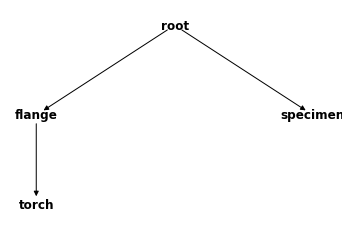

In [6]:
csm.plot_graph()

Inside of ipython notebooks like this one, the `CoordinateSystemManager.__repr__` function is replaced by another one that calls the `plot_graph` function. So it is sufficient to place the name of a `CoordinateSystemManager` instance at the end of a code cell to plot its graph:

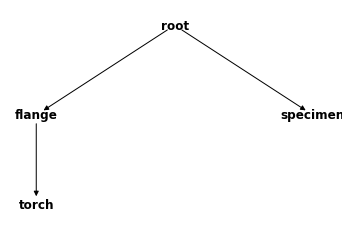

In [7]:
csm

## Transform coordinate systems to another reference system

After all coordinate systems are added to the `CoordinateSystemManager`, getting a coordinate system in relation to any other reference system in form of a `LocalCoordinateSystem` class is quite easy. Simply call `get_cs`. The name of the system that should be transformed is passed to the function as first parameter. The second parameter is the name of the target reference system. If it is omitted, the parent system is used as reference.

In [8]:
lcs_root_in_root = csm.get_cs("root", "root")
lcs_torch_in_root = csm.get_cs("torch", "root")
lcs_flange_in_root = csm.get_cs("flange")
lcs_specimen_in_root = csm.get_cs("specimen")

lcs_root_in_torch = csm.get_cs("root", "torch")
lcs_torch_in_torch = csm.get_cs("torch", "torch")
lcs_flange_in_torch = csm.get_cs("flange", "torch")
lcs_specimen_in_torch = csm.get_cs("specimen", "torch")

The following plots show the different systems in the root coordinate system and in the torch coordinate system:

<Axes3DSubplot:title={'center':'torch system'}>

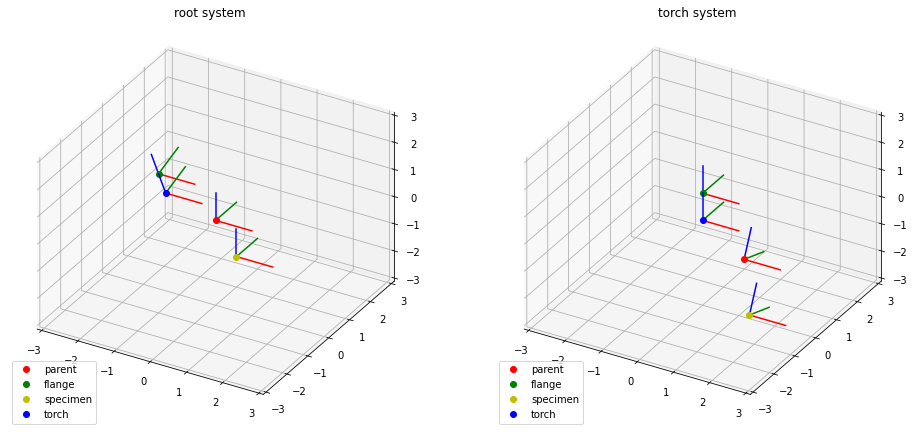

In [9]:
_, (ax_0_01, ax_1_01) = vs.new_3d_figure_and_axes(num_subplots=2, width=800, height=400)

# first plot
vs.plot_coordinate_systems([(lcs_root_in_root, {"color":"r", "label":"parent"}), 
                            (lcs_flange_in_root, {"color":"g", "label":"flange"}), 
                            (lcs_specimen_in_root, {"color":"y", "label":"specimen"}), 
                            (lcs_torch_in_root, {"color":"b", "label":"torch"})],
                           axes=ax_0_01,
                           limits=[-3, 3],
                           title="root system")


# second plot
vs.plot_coordinate_systems([(lcs_root_in_torch, {"color":"r", "label":"parent"}), 
                            (lcs_flange_in_torch, {"color":"g", "label":"flange"}), 
                            (lcs_specimen_in_torch, {"color":"y", "label":"specimen"}), 
                            (lcs_torch_in_torch, {"color":"b", "label":"torch"})],
                           axes=ax_1_01,
                           limits=[-3, 3],
                           title="torch system")

# Visualizing the coordinate systems of the CSM

Note that we used a utility function of the `weldx.visualize` module in the previous section to plot all of the coordinate systems we extracted from the CSM to demonstrate that the transformations are calculated correctly. However, if you want to visualize all coordinate systems of the CSM in relation to a specific reference system, you can simply use its `plot` function:

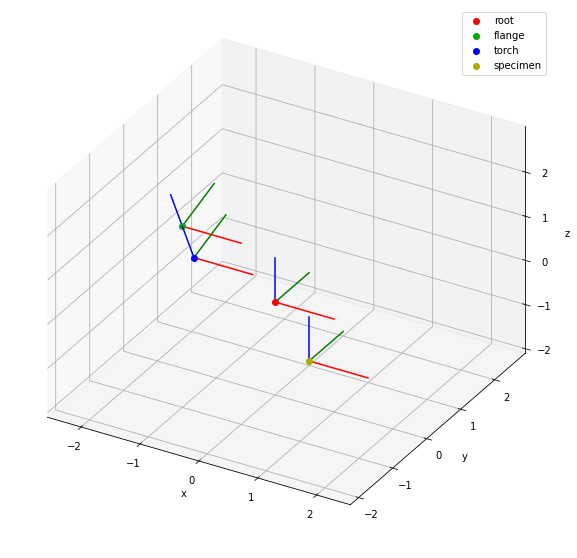

In [10]:
csm.plot_coordinate_systems(backend="mpl")

The plot function offers many parameters to adjust the resulting plot. One of them is to select a render backend. The default backend is matplotlib but for jupyter notebooks you can also use "k3d" which provides interactive plots. To test it, you can set the `backend` property of the previous command to `"k3d"` and rerun the cell. However, all time related controls will be disabled since the CSM only contains static coordinate systems. Consult the API documentation for further information on the plot function.

Furthermore, the plot function also visualizes spatial data that is attached to the CSM. How spatial data is added will be shown later in this tutorial.

## Renaming existing coordinate systems
Existing coordinate system nodes can be renamed using `CoordinateSystemManager.relabel`.

*Note: it is not possible to rename nodes on `CSM` instances that contain subsystems of any form.*

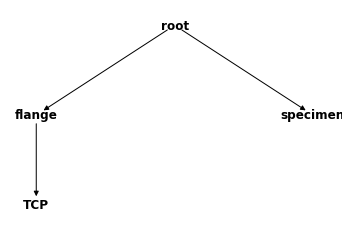

In [11]:
csm.relabel({"torch":"TCP"})
csm

In [12]:
csm.relabel({"TCP":"torch"})

## Updating and deleting coordinate system transformations

A coordinate system can be updated by simply calling `add_cs` again with the correct reference system and an updated `LocalCoordinateSystem` instance. For example, to update the torch system, one could do the following:

In [13]:
csm.add_cs("torch", "flange", tf.LocalCoordinateSystem(coordinates=[0,0,-2]))

Lets check if the values have changed

In [14]:
csm.get_cs("torch", "flange")

<LocalCoordinateSystem>
Dimensions:      (c: 3, v: 3)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
Data variables:
    coordinates  (c) float64 0.0 0.0 -2.0
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0

As you can see, the system has been updated. 

If you want to remove a coordinate system, you have to call `delete_cs`. The function takes two parameters. The first one is the name of the coordinate system you want to delete. The second is a `bool` that controls if child coordinate systems should be deleted too or not. In case you set this parameter to `False` (default) and try to remove a coordinate system with children, an exception is raised. This is an extra layer of security to prevent unintentional deletion of multiple coordinate systems. Here is an example:

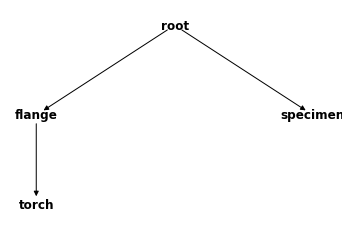

In [15]:
csm_copy = deepcopy(csm)
csm_copy

We made a copy of the `CoordinateSystemManager`. Now we are going to delete the specimen system, which has no other systems attached to it.

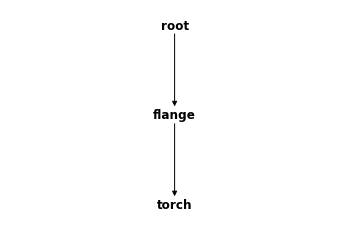

In [16]:
csm_copy.delete_cs("specimen")
csm_copy

That worked. Now lets try to remove the flange system:

In [17]:
try:
    csm_copy.delete_cs("flange")
except:
    print("Something went wrong! An exception was raised")

Something went wrong! An exception was raised


Since the torch system is a child of the flange system and we didn't tell the function to delete child systems as well, an exception was raised. Lets retry this, but this time we will tell the function that we want child systems to be removed too:

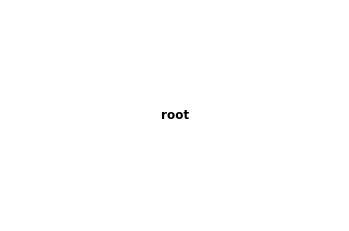

In [18]:
csm_copy.delete_cs("flange", True)
csm_copy

As you can see, we were successful and only the root system is left in the `CoordinateSystemManager` instance.

## Assignment and transformation of spatial data

A coordinate system stored in the `CoordinateSystemManager` can also get spatial data assigned to it. For example, this might be a sensor positions or geometry data in form of a point clouds. In this case it becomes the data's reference system and all values refer to its coordinate origin. 

Data can be assigned to a coordinate system with the `assign_data` function. It expects 3 parameters. The first one is the actual data. Currently, `xarray.DataArray` is the only supported type. The second parameter is a name of the data and the third one the name of the coordinate system that the data belongs to. In the following lines we define and assign some data to the `CoordinateSystemManager`.

In [19]:
sensor_positions_in_root = xr.DataArray(
    [[0, -1, 0], [0, -2, 0]], dims=["n", "c"], coords={"c": ["x", "y", "z"]}
)

specimen_geometry_in_specimen = xr.DataArray(
    [
        [0, 1, 0],
        [1, 1, 0],
        [2, 1, 0],
        [0, 2, 0],
        [1, 2, 0],
        [2, 2, 0],
        [0, 3, 0],
        [1, 3, 0],
        [2, 3, 0],
        [0, 4, 0],
        [1, 4, 0],
        [2, 4, 0],
    ],
    dims=["n", "c"],
    coords={"c": ["x", "y", "z"]},
)

csm.assign_data(sensor_positions_in_root, "sensors", "root")
csm.assign_data(specimen_geometry_in_specimen, "specimen geometry", "specimen")

With the `get_data` function, the unmodified data can be retrieved from the `CoordinateSystemManager` using its name as first parameter. 

In [20]:
assert specimen_geometry_in_specimen.identical(csm.get_data("specimen geometry"))

The optional second parameter can be used to get the data transformed into any of the `CoordinateSystemManager`s coordinate systems. You just need to specify the desired target coordinate systems name:

In [21]:
specimen_geometry_in_root = csm.get_data("specimen geometry", "root")

sensor_positions_in_torch = csm.get_data("sensors", "torch")
specimen_geometry_in_torch = csm.get_data("specimen geometry", "torch")

Here is a plot of the specified data in the root and torch coordinate system.

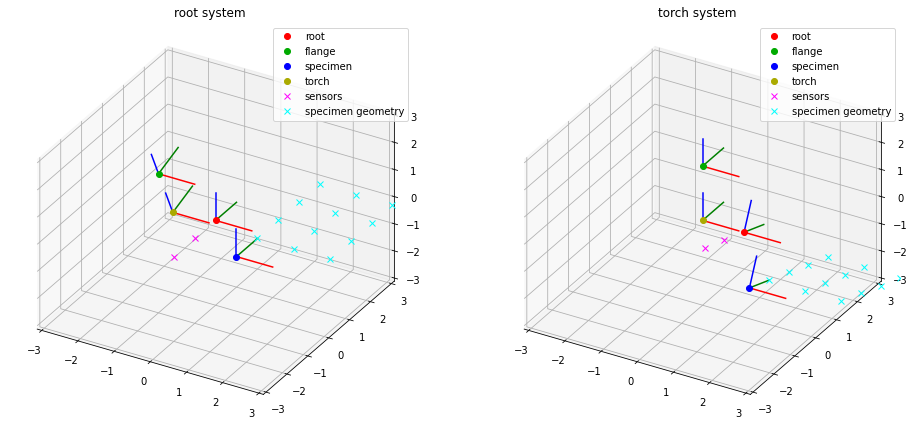

In [22]:
# plot coordinate systems
_, (ax_0_02, ax_1_02) = vs.new_3d_figure_and_axes(num_subplots=2, width=800, height=400)

# first plot
csm.plot_coordinate_systems(title="root system", limits=[(-3,3)], axes=ax_0_02)

# second plot
csm.plot_coordinate_systems(reference_system="torch", title="torch system", limits=[(-3,3)], axes=ax_1_02)

It is not necessary to attach data to a coordinate system to transform it to another one. The `CoordinateSystemManager` also provides the `transform_data` function for this purpose. It expects 3 parameters. The first parameter is the actual data and must be a `numpy.ndarray` or an `xarray.DataArray`. The second one is the source system name and the third one the target systems' name:

In [23]:
assert csm.transform_data(specimen_geometry_in_specimen, "specimen", "root").identical(
    specimen_geometry_in_root
)

## Time dependencies

As described in the previous tutorial about the `LocalCoordinateSystem` class, the orientation of a coordinate system towards its reference system might vary in time.
From the API side, time dependent coordinate systems are not treated any different than constant coordinate systems.
However, the `get_cs` function needs to perform some time interpolations internally if the timestamps of all involved coordinate systems aren't identical.
You might wonder which times the resulting interpolated `LocalCoordinateSystem` possesses.
The default behavior is that its timestamps are the time union of all coordinate systems participating in the transformation.
However, you can also provide the desired timestamps as a `pandas.TimedeltaIndex` or `pandas.DatetimeIndex` object using the `time` parameter of the `get_cs` function. Another method is to pass the name of a coordinate system that should provide the timestamps to the `time` parameter.

Let's define a new `CoordinateSystemManager` to demonstrate the different approaches:

In [24]:
parent_time = pd.TimedeltaIndex([1, 6], "D")
parent_coords = [[1, -1, 0], [0, -1, 0]]
parent_orientation = tf.rotation_matrix_z([0, np.pi / 2])

child_time = pd.TimedeltaIndex([2, 5], "D")
child_coords = [0, 2, 0]
child_orientation = tf.rotation_matrix_z([0, np.pi / 2])


childchild_time = pd.TimedeltaIndex([3, 4], "D")
childchild_coords = [2, 0, 0]
childchild_orientation = tf.rotation_matrix_z([0, np.pi / 2])


csm_tdp = tf.CoordinateSystemManager("root")
csm_tdp.create_cs(
    "parent",
    "root",
    coordinates=parent_coords,
    orientation=parent_orientation,
    time=parent_time,
)
csm_tdp.create_cs(
    "child",
    "parent",
    coordinates=child_coords,
    orientation=child_orientation,
    time=child_time,
)
csm_tdp.create_cs(
    "child child",
    "child",
    coordinates=childchild_coords,
    orientation=childchild_orientation,
    time=childchild_time,
)

Now we request from the `CoordinateSystemManager` to transform all coordinate systems to the `"root"` system: 

In [25]:
# default
lcs_parent_in_root_default = csm_tdp.get_cs("parent")
lcs_child_in_root_default = csm_tdp.get_cs("child", "root")
lcs_childchild_in_root_default = csm_tdp.get_cs(
    "child child", "root"
)

# specific times
time = pd.TimedeltaIndex([12 * (i + 1) for i in range(12)], "H")
lcs_parent_in_root_time = csm_tdp.get_cs("parent", time=time)
lcs_child_in_root_time = csm_tdp.get_cs("child", "root", time=time)
lcs_childchild_in_root_time = csm_tdp.get_cs(
    "child child", "root", time=time
)

# reference system
lcs_parent_in_root_ref = csm_tdp.get_cs("parent", time="parent")
lcs_child_in_root_ref = csm_tdp.get_cs(
    "child", "root", time="parent"
)
lcs_childchild_in_root_ref = csm_tdp.get_cs(
    "child child", "root", time="parent"
)

C:\Users\vhirtham\PycharmProjects\bam\weldx\weldx\utility.py:437: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  return reduce(or_, (to_pandas_time_index(idx) for idx in list_of_objects))
C:\Users\vhirtham\PycharmProjects\bam\weldx\weldx\utility.py:437: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  return reduce(or_, (to_pandas_time_index(idx) for idx in list_of_objects))


Here is a plot showing the different results:

<Axes3DSubplot:title={'center':'"parent" as time reference'}>

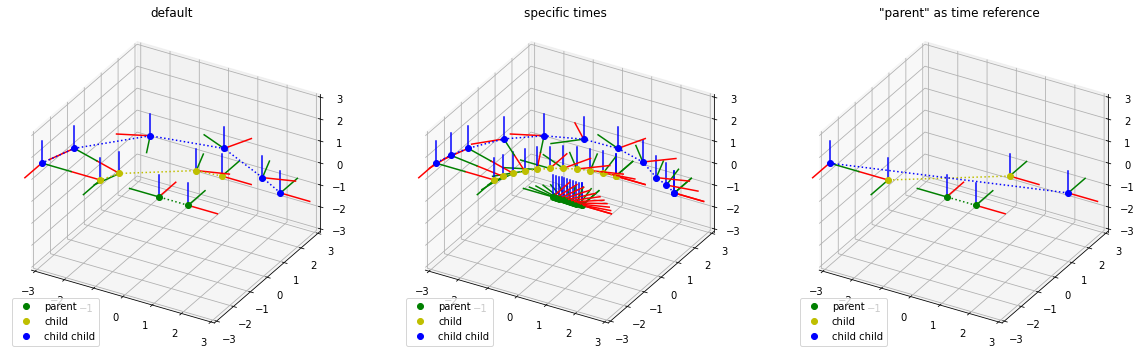

In [26]:
_, (ax_0_tdp, ax_1_tdp, ax_2_tdp) = vs.new_3d_figure_and_axes(num_subplots=3, width=1000, height=400)


vs.plot_coordinate_systems([(lcs_parent_in_root_default, {"color":"g", "label":"parent"}), 
                            (lcs_child_in_root_default, {"color":"y", "label":"child"}), 
                            (lcs_childchild_in_root_default, {"color":"b", "label":"child child"}) ],
                           axes=ax_0_tdp,
                           title="default",
                           limits=[-3, 3]
                          )

vs.plot_coordinate_systems([(lcs_parent_in_root_time, {"color":"g", "label":"parent"}), 
                            (lcs_child_in_root_time, {"color":"y", "label":"child"}), 
                            (lcs_childchild_in_root_time, {"color":"b", "label":"child child"}) ],
                           axes=ax_1_tdp,
                           title="specific times",
                           limits=[-3, 3]
                          )

vs.plot_coordinate_systems([(lcs_parent_in_root_ref, {"color":"g", "label":"parent"}), 
                            (lcs_child_in_root_ref, {"color":"y", "label":"child"}), 
                            (lcs_childchild_in_root_ref, {"color":"b", "label":"child child"}) ],
                           axes=ax_2_tdp,
                           title= '"parent" as time reference',
                           limits=[-3, 3]
                          )


The `CoordinateSystemManager` also has a `interp_time` method. By default, this will return a new instance where every coordinate system is interpolate to match the timestamps provided as first function parameter. Optionally, one can pass a list of coordinate system names that should be interpolated as second parameter. Coordinate systems that are not in the list remain unchanged. One can also choose to perform the operations "in place" modifying the current instance of the `CoordinateSystemManager`. Therefore, the third parameter `in_place` has to be set to `True`.

In [27]:
time_new = pd.TimedeltaIndex([1, 3, 5], "D") 

# default interpolation -------------------------
csm_tdp_interp = csm_tdp.interp_time(time_new)

assert np.all(csm_tdp_interp.get_cs("parent").time == time_new)
assert np.all(csm_tdp_interp.get_cs("child").time == time_new)
assert np.all(
    csm_tdp_interp.get_cs("child child").time == time_new
)

# selective interpolation -----------------------
csm_tdp_interp = csm_tdp.interp_time(time_new, affected_coordinate_systems=["child", "child child"])

assert np.all(
    csm_tdp_interp.get_cs("parent").time
    == csm_tdp.get_cs("parent").time
)
assert np.all(csm_tdp_interp.get_cs("child").time == time_new)
assert np.all(
    csm_tdp_interp.get_cs("child child").time == time_new
)

# in place interpolation ------------------------
csm_tdp_interp = deepcopy(csm_tdp)
csm_tdp_interp.interp_time(time_new, in_place=True)

assert np.all(csm_tdp_interp.get_cs("parent").time == time_new)
assert np.all(csm_tdp_interp.get_cs("child").time == time_new)
assert np.all(
    csm_tdp_interp.get_cs("child child").time == time_new
)



## Merging and unmerging

Sometimes a larger hierarchy of coordinate systems can be subdivided into multiple smaller subsystems.
Defining them individually might be more intuitive and easier.
For this reason, the `CoordinateSystemManager` provides the possibility to merge an instance into another one.
We will introduce this functionality with a short example.

Consider an automated welding process, where the torch is moved by a robot arm.
The robot provides two mount points for additional equipment.
We know where the torch and the mount points are located in the moving robot head coordinate system.
So we can define the following `CoordinateSystemManager` instance to describe the setup:

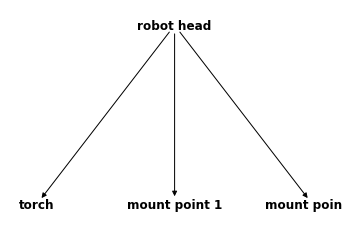

In [28]:
csm_robot = tf.CoordinateSystemManager("robot head", "robot coordinate systems")
csm_robot.create_cs("torch", "robot head", coordinates=[0, 0, -2])
csm_robot.create_cs("mount point 1", "robot head", coordinates=[0, 1, -1])
csm_robot.create_cs("mount point 2", "robot head", coordinates=[0, -1, -1])
csm_robot

As extra measurement equipment we have a laser scanner that we want to attach to the first mounting point. It uses its own coordinate system and all the gathered data refers to it. We know the coordinates of the scanners own mount point inside this system so that we can define:

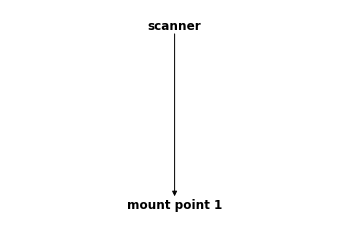

In [29]:
csm_scanner = tf.CoordinateSystemManager("scanner", "scanner coordinate systems")
csm_scanner.create_cs("mount point 1", "scanner", coordinates=[0, 0, 2])
csm_scanner

Note that the coordinate system "mount point 1" was added to both `CoordinateSystemManager` instances. Merging requires that both instances share exactly one common coordinate system that serves as connecting node.

Now we merge the scanner coordinate systems with the robot coordinate systems using the `merge` function:

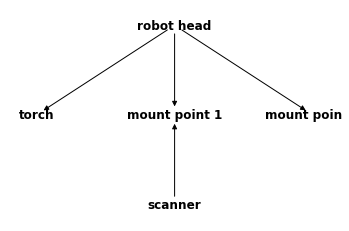

In [30]:
csm_robot.merge(csm_scanner)
csm_robot

You can see in the output above that the scanner coordinate systems were successfully merged into the `CoordinateSystemManager` instance containing the robot data. Let's define some additional `CoordinateSystemManager` instances:

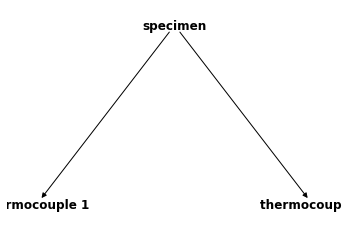

In [31]:
csm_specimen = tf.CoordinateSystemManager("specimen", "specimen coordinate systems")
csm_specimen.create_cs("thermocouple 1", "specimen", coordinates=[1, 1, 0])
csm_specimen.create_cs("thermocouple 2", "specimen", coordinates=[1, 4, 0])
csm_specimen

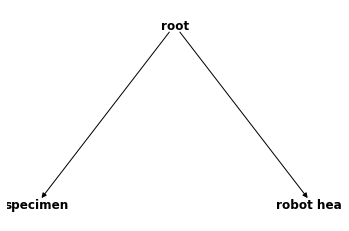

In [32]:
csm_global = tf.CoordinateSystemManager("root", "global coordinate systems")
csm_global.create_cs("specimen", "root", coordinates=[1, 2, 3])
csm_global.create_cs("robot head", "root", coordinates=[4, 5, 6])
csm_global

Now we merge them all:

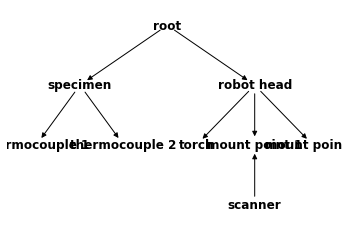

In [33]:
csm_global.merge(csm_robot)
csm_global.merge(csm_specimen)
csm_global

All coordinate systems are now collected in a single `CoordinateSystemManager`.
We can extract the previously merged subsystems with the function `subsystems` property.
It returns a list with the `CoordinateSystemManager` instances:

In [34]:
csm_list = csm_global.subsystems
for sub_csm in csm_list:
    print(sub_csm.name)

robot coordinate systems
specimen coordinate systems


Comparing the returned `CoordinateSystemManager` instances with the original ones shows that they are indeed identical:

In [35]:
for sub_csm in csm_list:
    if sub_csm.name == "robot coordinate systems":
        print(sub_csm == csm_robot)
    else:
        print(sub_csm == csm_specimen)

True
True


You might have noticed, that there is no `CoordinateSystemManager` for the scanner systems.
The reason for this is that it is a subsystem of the robot coordinate systems and the `subsystems` property does not recursively extract nested subsystems.
However, we can simply use `subsystems` a second time to get it:

In [36]:
for sub_csm in csm_list:
    if sub_csm.name == "robot coordinate systems":
        print(sub_csm.subsystems[0].name)

scanner coordinate systems


Using the `subsystems` property does not affect the state of the current `CoordinateSystemManager`:

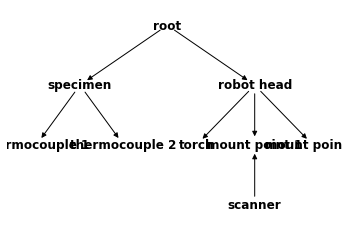

In [37]:
csm_global

To remove all subsystems, you can call `remove_subsystems`:

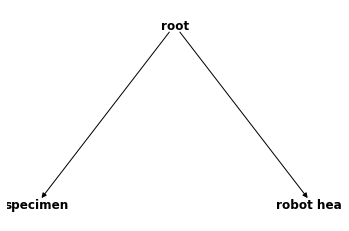

In [38]:
csm_global.remove_subsystems()
csm_global

Alternatively, if you want to decompose a `CoordinateSystemManager` instance into all its subsystems, you can use the `unmerge` function.
It works exactly the same as the `subsystems` property with the difference that it also removes all subsystem data from the affected `CoordinateSystemManager` instance.